# <center> Detecting and Evaluating Visual Pollution in Street Imagery from Moving Vehicles </center>

## Table of Contents:
* ## [Introduction](#intro)
* ## [Exploratory Data Analysis](#eda):
    - ### [Data Description](#info)
    - ### [Visual Examples and Insights](#viz)
* ## [Data Preprocessing](#preprocessing)
* ## [Modeling](#modeling)
* ## [Results and Evaluation](#results):
    - ### [Evaluation Metrics](#metrics)
    - ### [Key Findings](#inf)


## Introduction <a class="anchor" id="intro"></a>
In this project, inspired by our research published in the *International Journal on Recent and Innovation Trends in Computing and Communication (2023)*, we focus on detecting and evaluating **visual pollution** in street-level imagery captured from a moving vehicle.

Visual pollution refers to elements in urban environments that obstruct or degrade visual aesthetics, including unauthorized signboards, excessive advertisements, and poorly maintained infrastructure. Our approach integrates computer vision techniques and deep learning to automatically classify and assess such pollutants from images taken in real-time during vehicle movement.

This notebook demonstrates our complete pipeline: from understanding the dataset to building models that can distinguish polluted images from clean ones, along with performance evaluation.

<b>This notebook goes over the procedure followed to replicate our submission.</b>

### Importing libraries

In [ ]:
# data handling
import pandas as pd
import numpy as np
import glob 

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import Image
import IPython
from tqdm import tqdm

# modeling
import torch

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


### Loading the data

<b> Note: </b> <br><br>
We assumne that the provided dataset is unzipped and is in the same directory as this notebook.

<b>Project Structure is as follows:</b>

    .
    ├── main.ipynb
    ├── coco
    ├── assets
    ├── dataset
    |   ├── images
    │   │   ├── *.jpg
    │   ├── train.csv
    │   ├── test.csv
    │   └── sample_submission.csv
    ├── models
    │   └── pattrn
    ├── results
    │   └── pattrn.csv
    ├── EDI.yaml
    ├── requirements.txt
    └── README.md


In [ ]:
df_train = pd.read_csv('dataset/train.csv')

# chanege the path of each image to make it easier to load
df_train['image_path'] = 'dataset/images/' + df_train['image_path']
df_train.head()

class                                         image_path           name  \
0    3.0  dataset/images/4a48c42c9579ec0399e6c5a3e825e76...        GARBAGE   
1    3.0  dataset/images/4a48c42c9579ec0399e6c5a3e825e76...        GARBAGE   
2    3.0  dataset/images/4a48c42c9579ec0399e6c5a3e825e76...        GARBAGE   
3    7.0  dataset/images/ea906a663da6321bcef78be4b7d1aff...  BAD_BILLBOARD   
4    8.0  dataset/images/1c7d48005a12d1b19261b8e71df7caf...   SAND_ON_ROAD   

    xmax   xmin   ymax   ymin  
0  797.0  701.0  262.0  211.0  
1  932.0  786.0  329.0  238.0  
2  736.0  657.0  275.0  229.0  
3  986.0  786.0  136.0    0.0  
4  667.0  549.0  228.0  179.0

<b>To handle the issue of the bounding boxes' coordinates, instead of multiplying them by two, we decided to resize the images to 960x540.</b>

In [ ]:
# resize each image to 960x540 and overwrite the original image
for i in tqdm(range(len(df_train))):
    img = cv2.imread(df_train['image_path'][i])
    img = cv2.resize(img, (960, 540))
    cv2.imwrite(df_train['image_path'][i], img)

100%|██████████| 19950/19950 [05:46<00:00, 57.58it/s]


## Exploratory Data Analysis <a class="anchor" id="eda"></a>

### Data Information <a class="anchor" id="info"></a>

In [ ]:
# get data info
print('Train data shape: ', df_train.shape)

# check for missing values
print('Train data missing values: ', df_train.isnull().sum().sum())

# check for duplicates
print('Train data duplicates: ', df_train.duplicated().sum())

Train data shape:  (19950, 7)
Train data missing values:  0
Train data duplicates:  0


<b>The training data has no missing values, nor duplicates.</b>

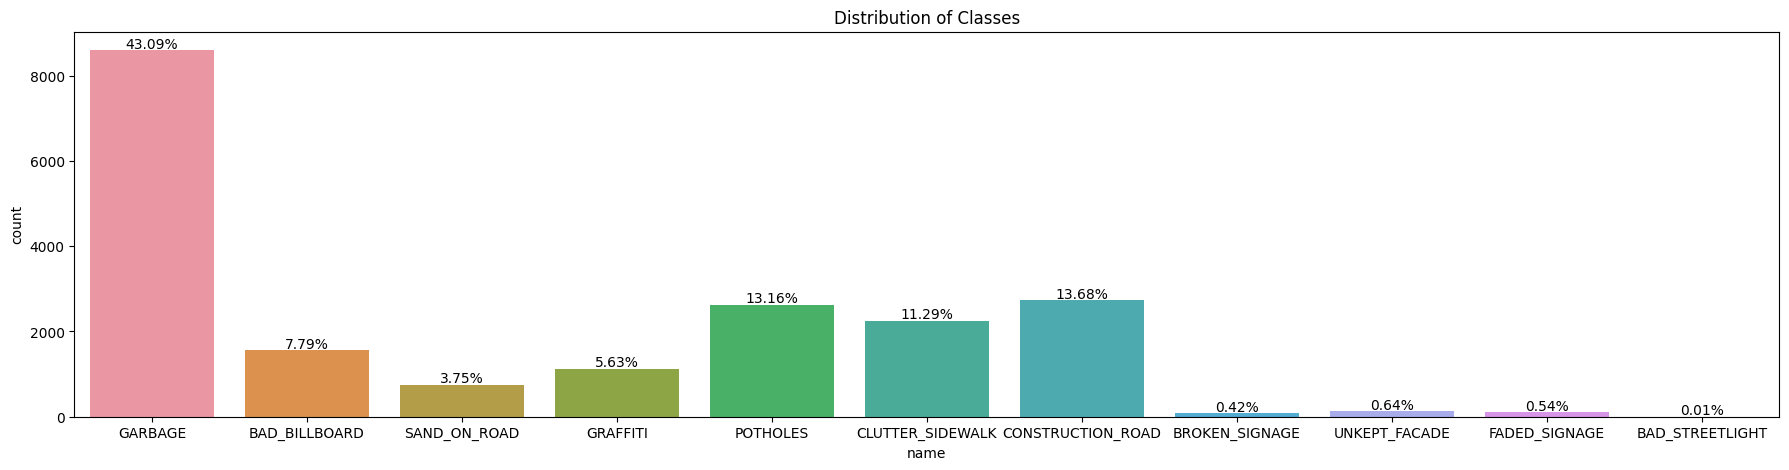

In [ ]:
# visualize the distribution of each class
plt.figure(figsize=(22, 5))
sns.countplot(x='name', data=df_train)
plt.title('Distribution of Classes')
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x()+p.get_width()/2., height + 50, '{:1.2f}%'.format(100*height/len(df_train)), ha="center")
plt.show()

- <b> It is apparent that the dataset is heavily imbalanced, and we'll handle that later. </b>
- <b> We can also see that the BAD_STREETLIGHT class has only 1 observation. </b>
- <b> Additionally, there are 4 classes that contribute to less than 1% of the data.</b>

### Data Visualization <a class="anchor" id="viz"></a>

#### Visualize some images from each class with their labels and bounding boxes.

POTHOLES:


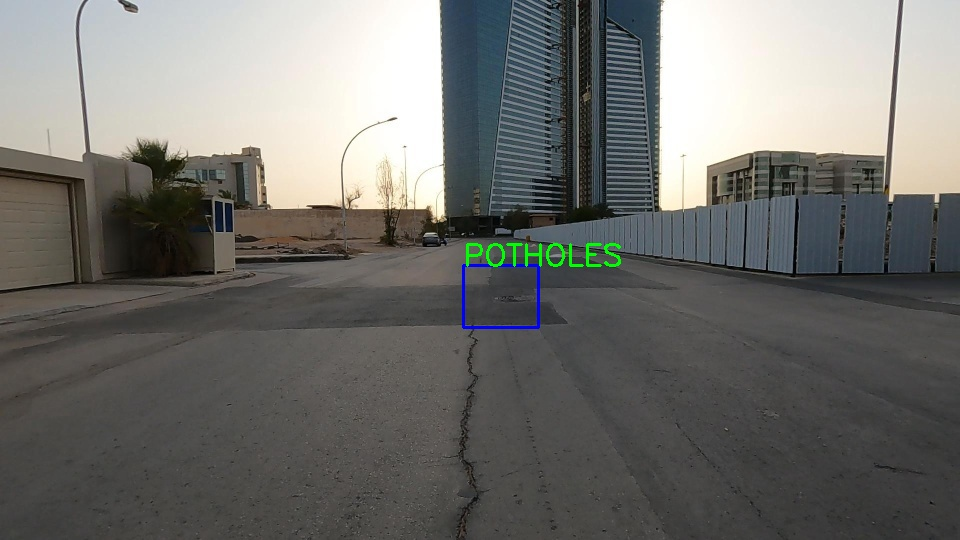

GRAFFITI:


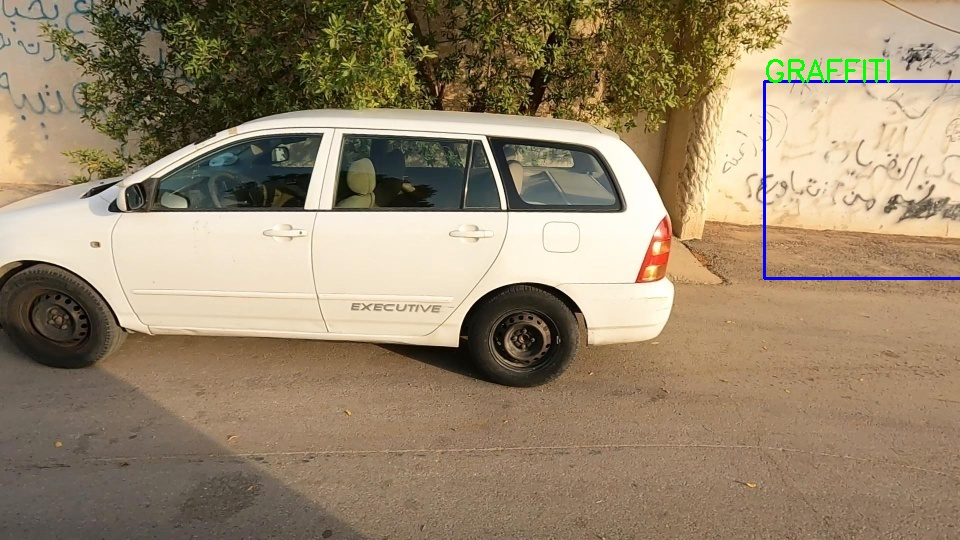

BAD_BILLBOARD:


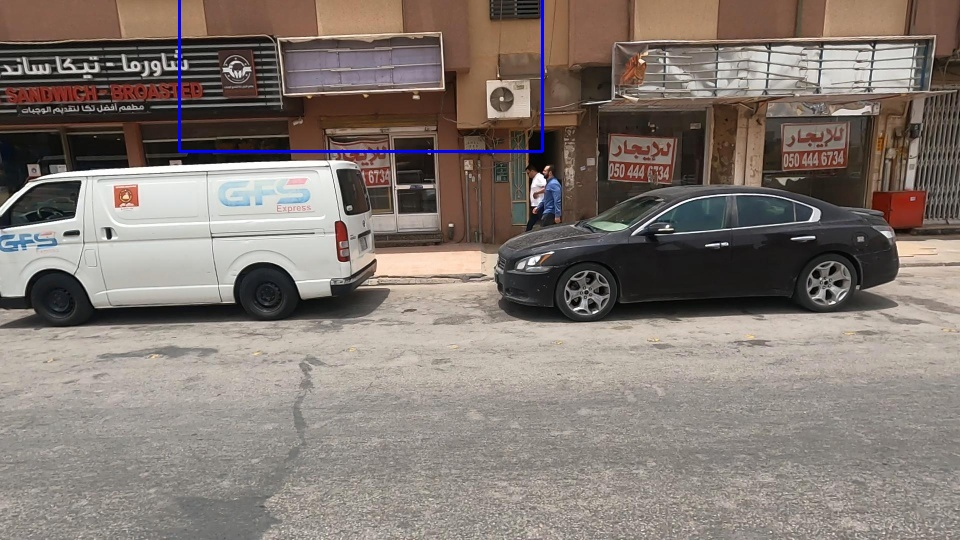

CLUTTER_SIDEWALK:


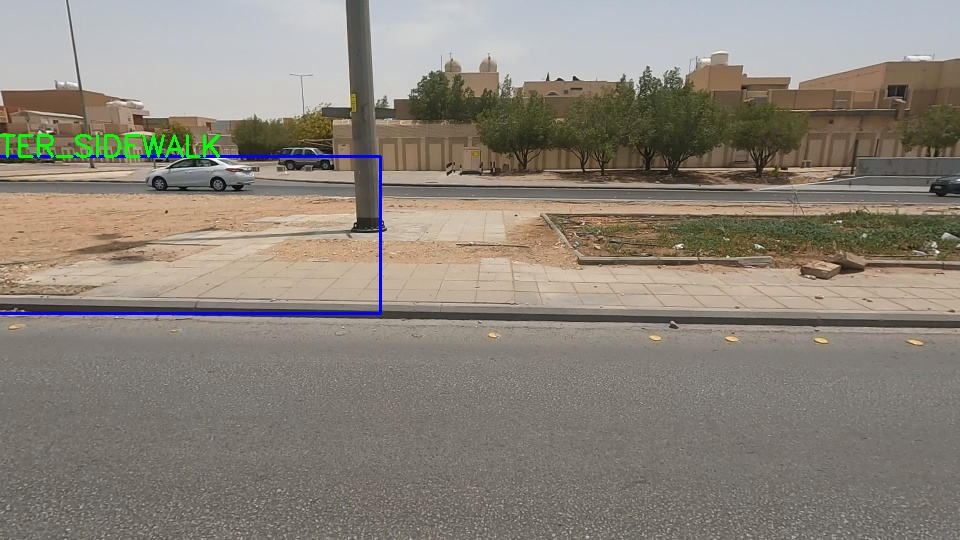

UNKEPT_FACADE:


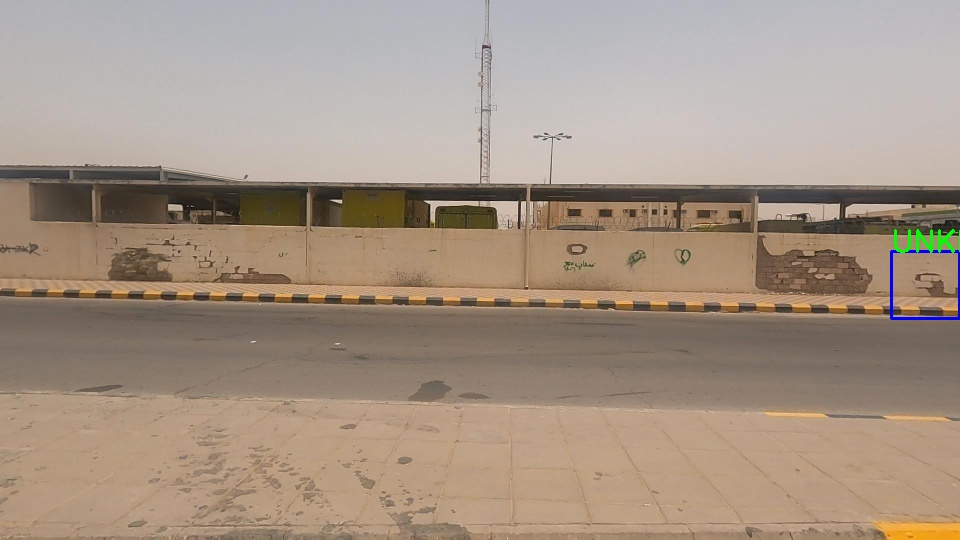

BAD_STREETLIGHT:


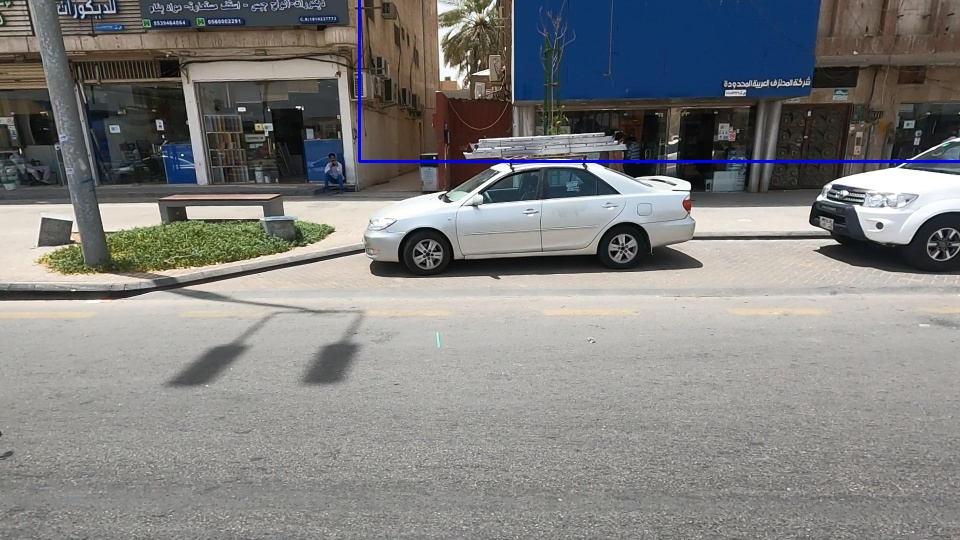

SAND_ON_ROAD:


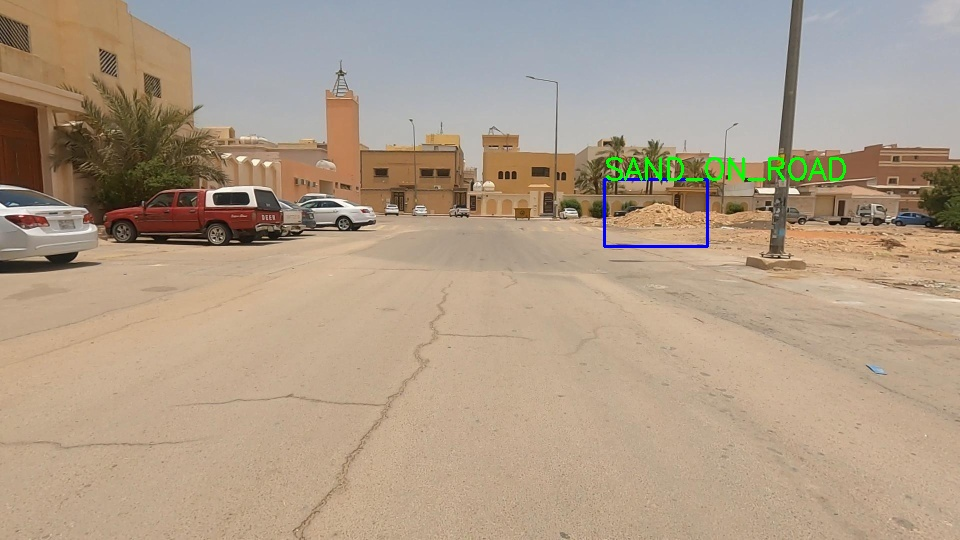

GARBAGE:


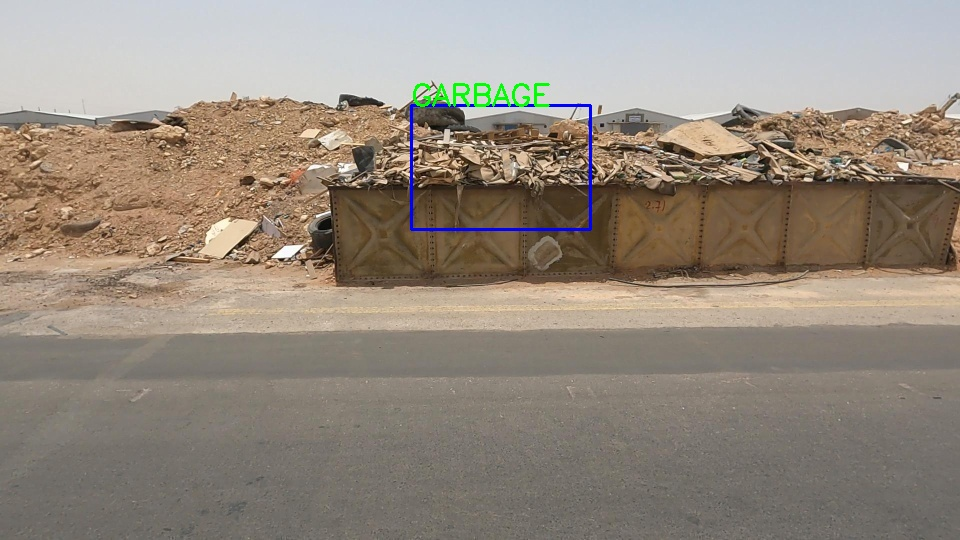

BROKEN_SIGNAGE:


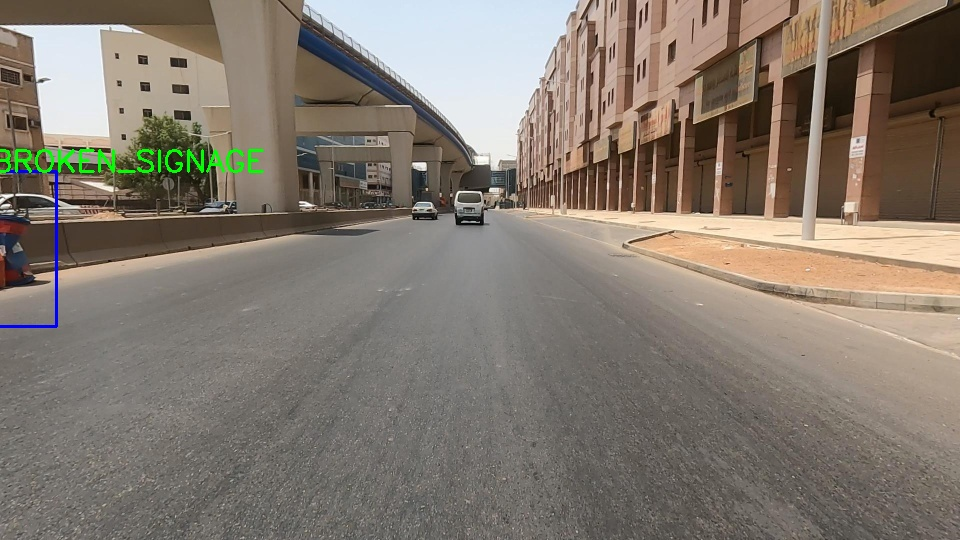

CONSTRUCTION_ROAD:


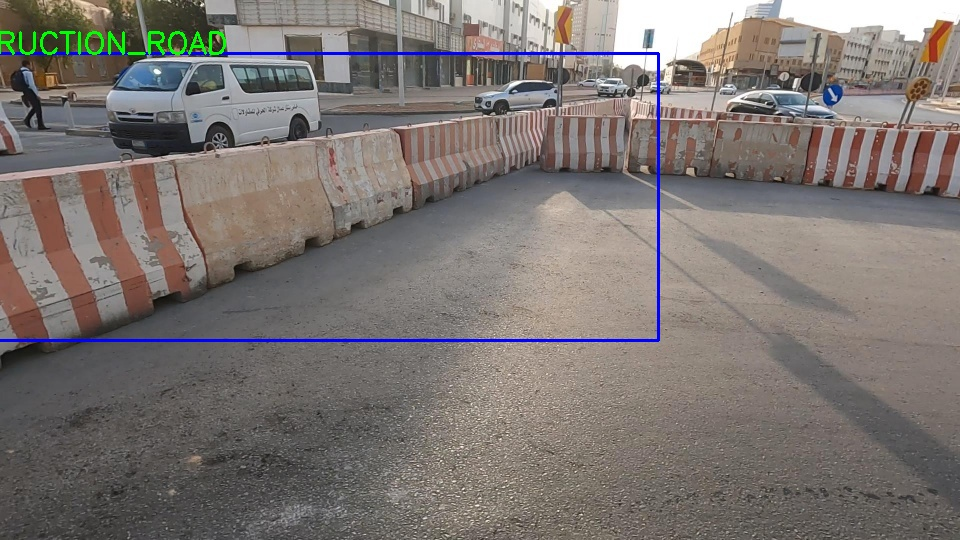

FADED_SIGNAGE:


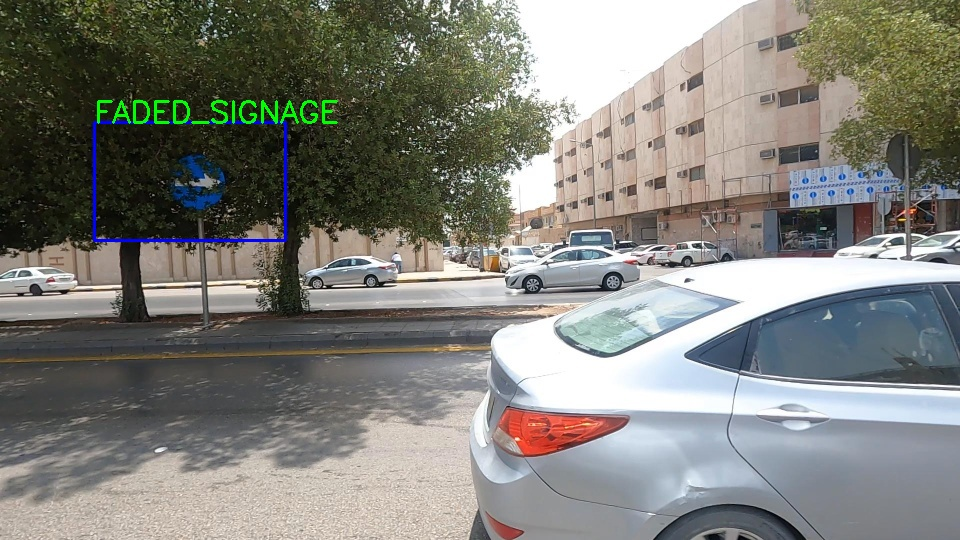

In [ ]:
a = df_train.groupby('name').apply(lambda x: x.sample(1)).reset_index(drop=True)

# convert coordinates to int for visualization
a['xmin'] = a['xmin'].astype(int)
a['ymin'] = a['ymin'].astype(int)
a['xmax'] = a['xmax'].astype(int)
a['ymax'] = a['ymax'].astype(int)

# get the bounding boxes and labels for each image
a = a.groupby('image_path')['xmin', 'ymin', 'xmax', 'ymax', 'name'].apply(lambda x: x.values.tolist()).reset_index(name='bboxes')
a['labels'] = a['bboxes'].apply(lambda x: [i[4] for i in x])
a['bboxes'] = a['bboxes'].apply(lambda x: [i[:4] for i in x])

# visualize the bounding boxes and labels
for i in range(len(a)):
    img = cv2.imread(a['image_path'].iloc[i])
    for j in range(len(a['bboxes'].iloc[i])):
        print(a['labels'].iloc[i][j]+":")
        cv2.rectangle(img, tuple(a['bboxes'].iloc[i][j][:2]), tuple(a['bboxes'].iloc[i][j][2:]), (255, 0, 0), 2)
        cv2.putText(img, a['labels'].iloc[i][j], tuple(a['bboxes'].iloc[i][j][:2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imwrite('assets/sample_images/{}.jpg'.format(i), img)
    display(Image('assets/sample_images/{}.jpg'.format(i)))


##### Issues with the labelling:
- <b> The labels are not consistent.</b>
- <b> Some objects of intereset are not labeled.</b>
- <b> Some objects are mislabeled.</b>
- <b> Some bounding boxes are too large.</b>

## Data Preprocessing <a class="anchor" id="preprocessing"></a>


<b> We decided to use [YOLOv5](https://github.com/ultralytics/yolov5) for our work. YOLOv5 requires the data to be in yolo format *normalized [x_center, y_center, width, height]*. <br><br>
However, the provided data is in pascal_voc format *[xmin, ymin, xmax, ymax]*. <br><br>
Therefore, in this section we'll convert the data from pascal_voc to yolo format.</b>


<b> We developed a package called [coco2yolo] that converts the data from pascal_voc to yolo format. </b>



<b> You can check out the code for exact details on the conversion, however, below, are the basic steps followed to perform the conversion.</b>
```python
# Convert from pascal_voc to yolo format

# Width and height of the image (after the resizing process). Used for normalization.
WIDTH = 960
HEIGHT = 540

# xmin, ymin, xmax, ymax are the coordinates of the bounding box taken from the training data.
def convert_sample(xmin, ymin, xmax, ymax):
    x_center = ((xmin + xmax) / 2) / WIDTH
    y_center = ((ymin + ymax) / 2) / HEIGHT
    width = (xmax - xmin) / WIDTH
    height = (ymax - ymin) / HEIGHT
    return x_center, y_center, width, height
```

<b> To perform the conversion, we execute the following command in the terminal:</b>

```bash
python -m coco2yolo
```

<b> This will create the *EDI* folder under the *dataset* folder<b>.<br>
<b> Additionally, it will split the data into training and validation sets. <b> <br>
<b> Moreover, we created the EDI.yaml file that contains the information about the classes and the number of classes.</b><br>

<b> The structre will be as follows:<b>

    .
    ├── main.ipynb
    ├── coco
    ├── assets
    ├── dataset
    |   ├── images
    │   │   ├── *.jpg
    │   ├── EDI
    │   │   ├── images
    │   │   │   ├── train
    │   │   │   │   ├── *.jpg
    │   │   │   ├── val
    │   │   │   │   ├── *.jpg
    │   │   ├── labels
    │   │   │   ├── train
    │   │   │   │   ├── *.txt
    │   │   │   ├── val
    │   │   │   │   ├── *.txt
    │   ├── train.csv
    │   ├── test.csv
    │   └── sample_submission.csv
    ├── models
    │   └── pattrn
    ├── results
    │   └── pattrn.csv
    ├── EDI.yaml
    ├── requirements.txt
    └── README.md


<b> Now, we have the data in the required format, and it is splitted into training and validation sets so we can move on to the training process.</b>

## Modeling <a class="anchor" id="modeling"></a>


<b> We'll be using the object detection architecture of YOLOv5 for training our model. </b>
<b> We used the following command to clone the YOLOv5 repository and install its dependencies:</b>

```bash
git clone https://github.com/ultralytics/yolov5
pip install -r yolov5/requirements.txt
```

<b> Now the file structure will be as follows:</b>

    .
    ├── main.ipynb
    ├── coco
    ├── assets
    ├── yolov5
    ├── dataset
    |   ├── images
    │   │   ├── *.jpg
    │   ├── EDI
    │   │   ├── images
    │   │   │   ├── train
    │   │   │   │   ├── *.jpg
    │   │   │   ├── val
    │   │   │   │   ├── *.jpg
    │   │   ├── labels
    │   │   │   ├── train
    │   │   │   │   ├── *.txt
    │   │   │   ├── val
    │   │   │   │   ├── *.txt
    │   ├── train.csv
    │   ├── test.csv
    │   └── sample_submission.csv
    ├── models
    │   └── pattrn
    ├── results
    │   └── pattrn.csv
    ├── EDI.yaml
    ├── requirements.txt
    └── README.md

<b> Hyperparameters we experimented with:</b>
- <b> Batch size </b>
- <b> Image size </b>
- <b> Augmentation (High and Low) </b>
- <b> Epochs </b>
- <b> Model architecture (YOLOv5s, YOLOv5l, YOLOv5x, YOLOv5x6) </b>

<b> We used the following command to train the best performing model:</b>

```bash
cd yolov5
python train.py --batch 16 --epochs 300 --data ../smartathon.yaml --weights yolov5x.pt --hyp data/hyps/hyp.scratch-high.yaml --device 0 --img 960
```

## Results <a class="anchor" id="results"></a>


<b> This section will showcase the model performance and some sample outputs from the test images.</b>

### Evaluation Metrics <a class="anchor" id="metrics"></a>

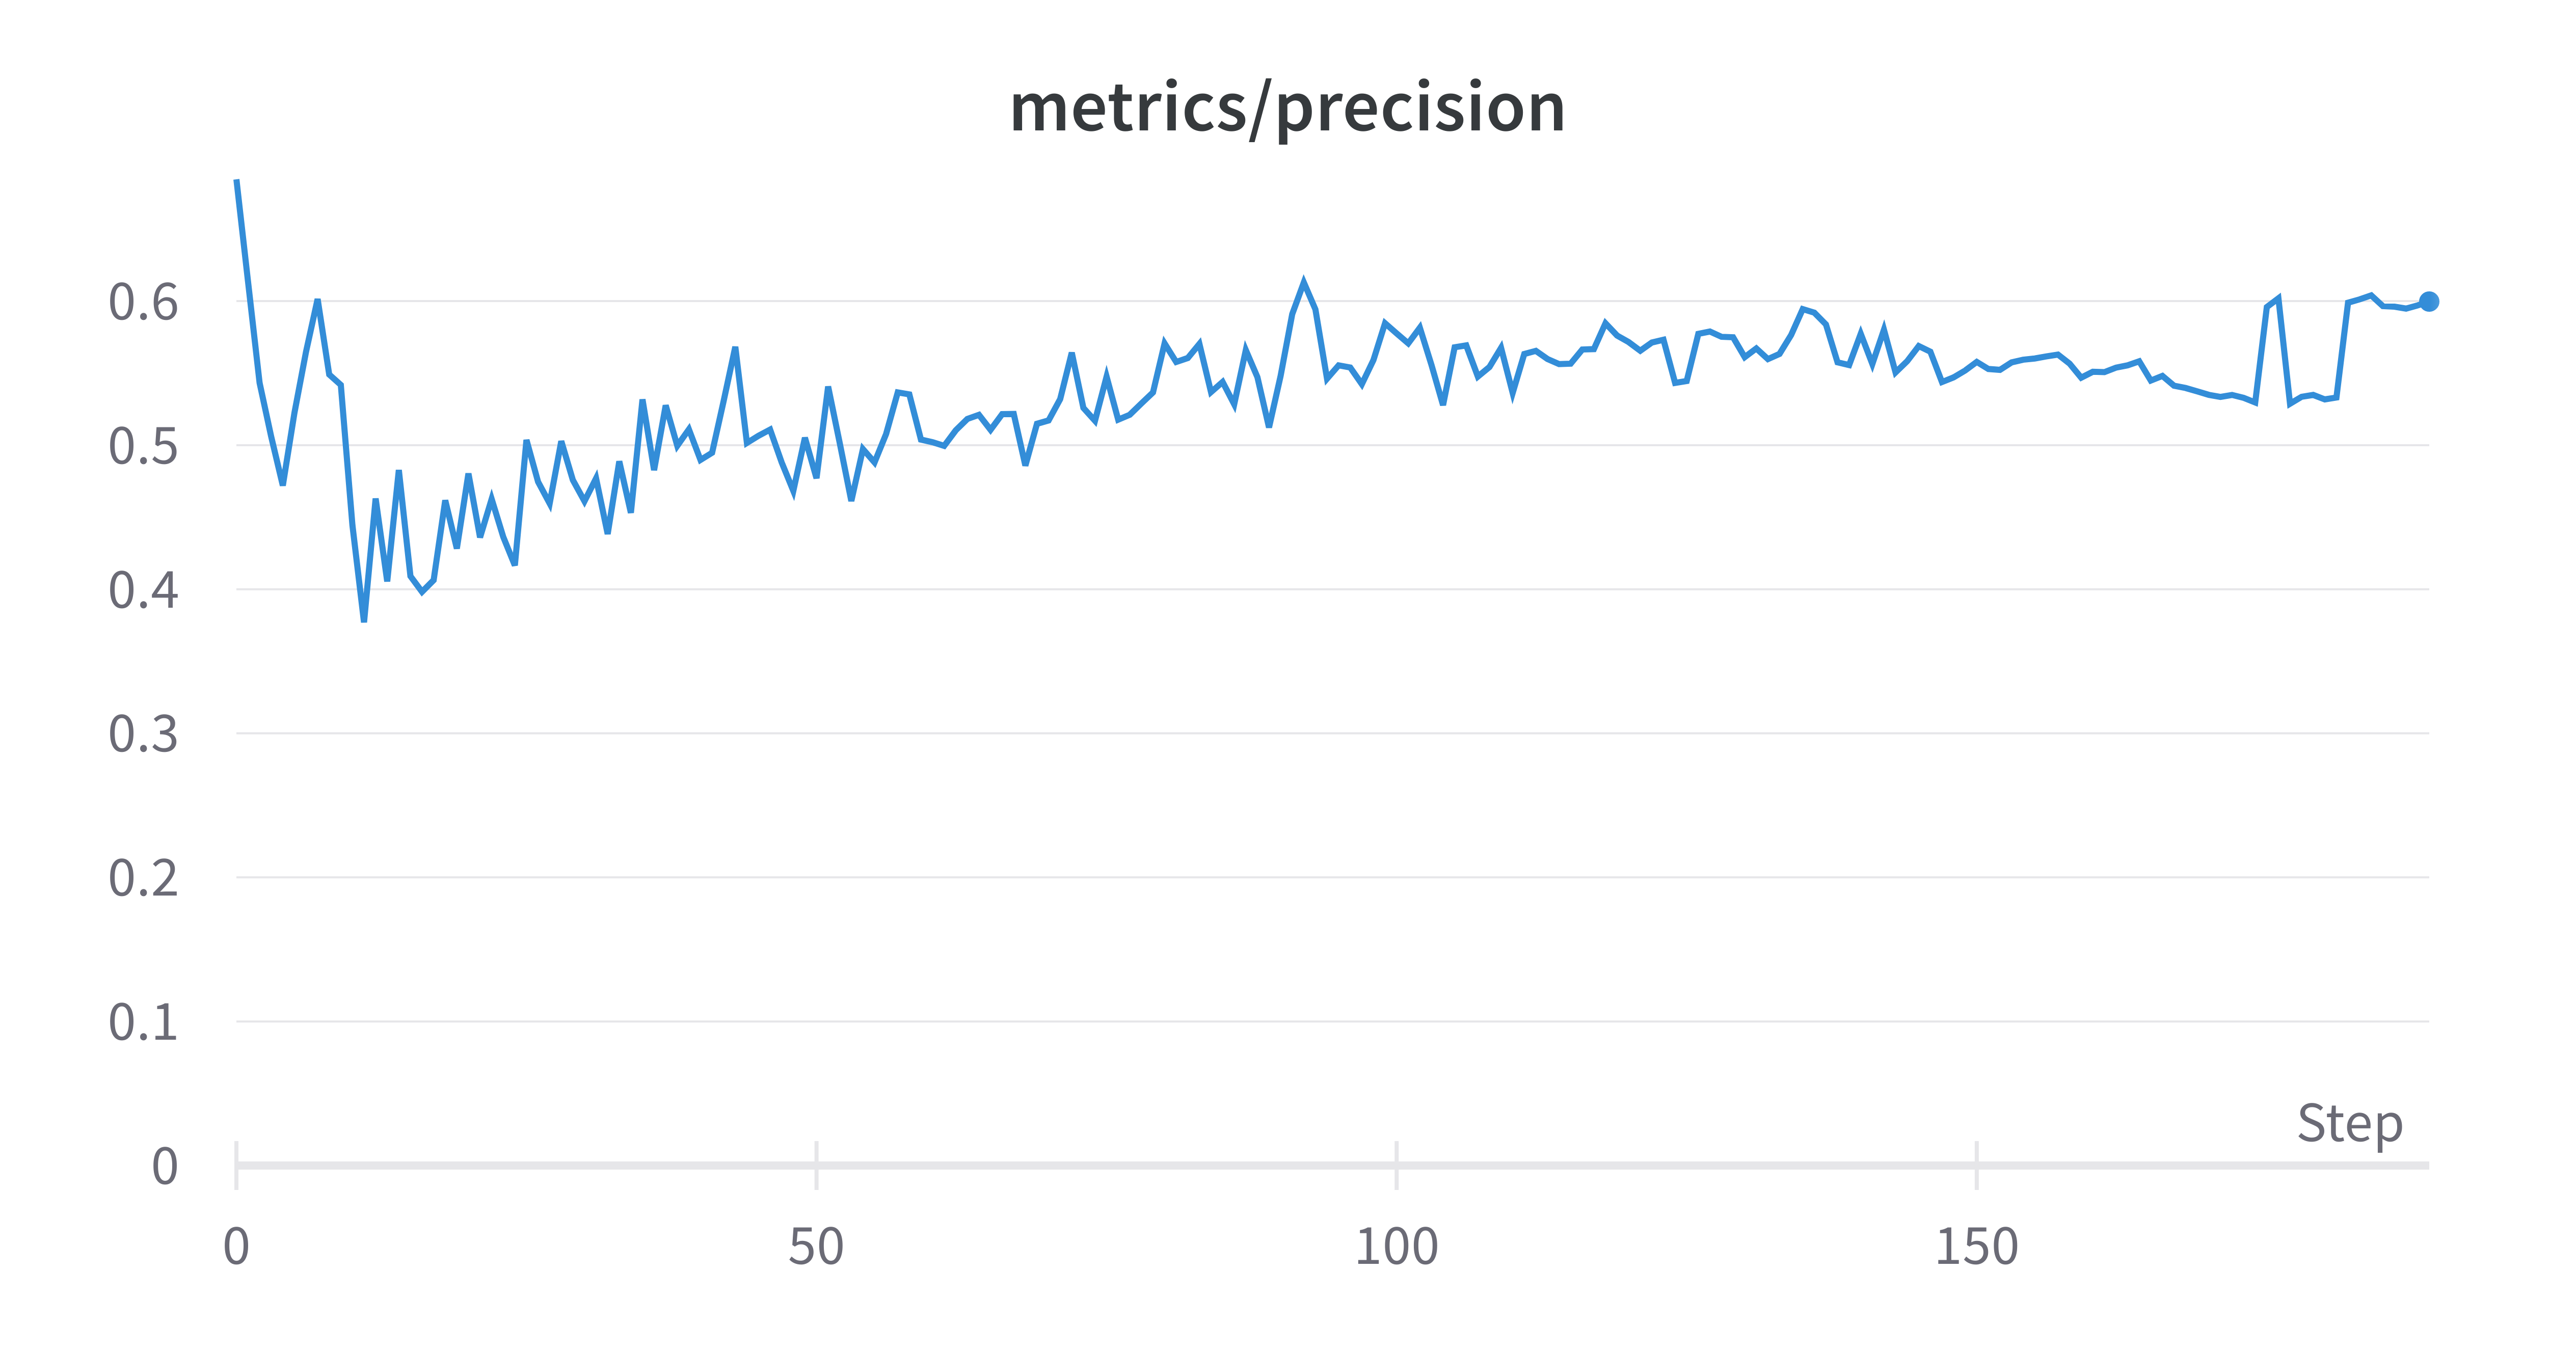

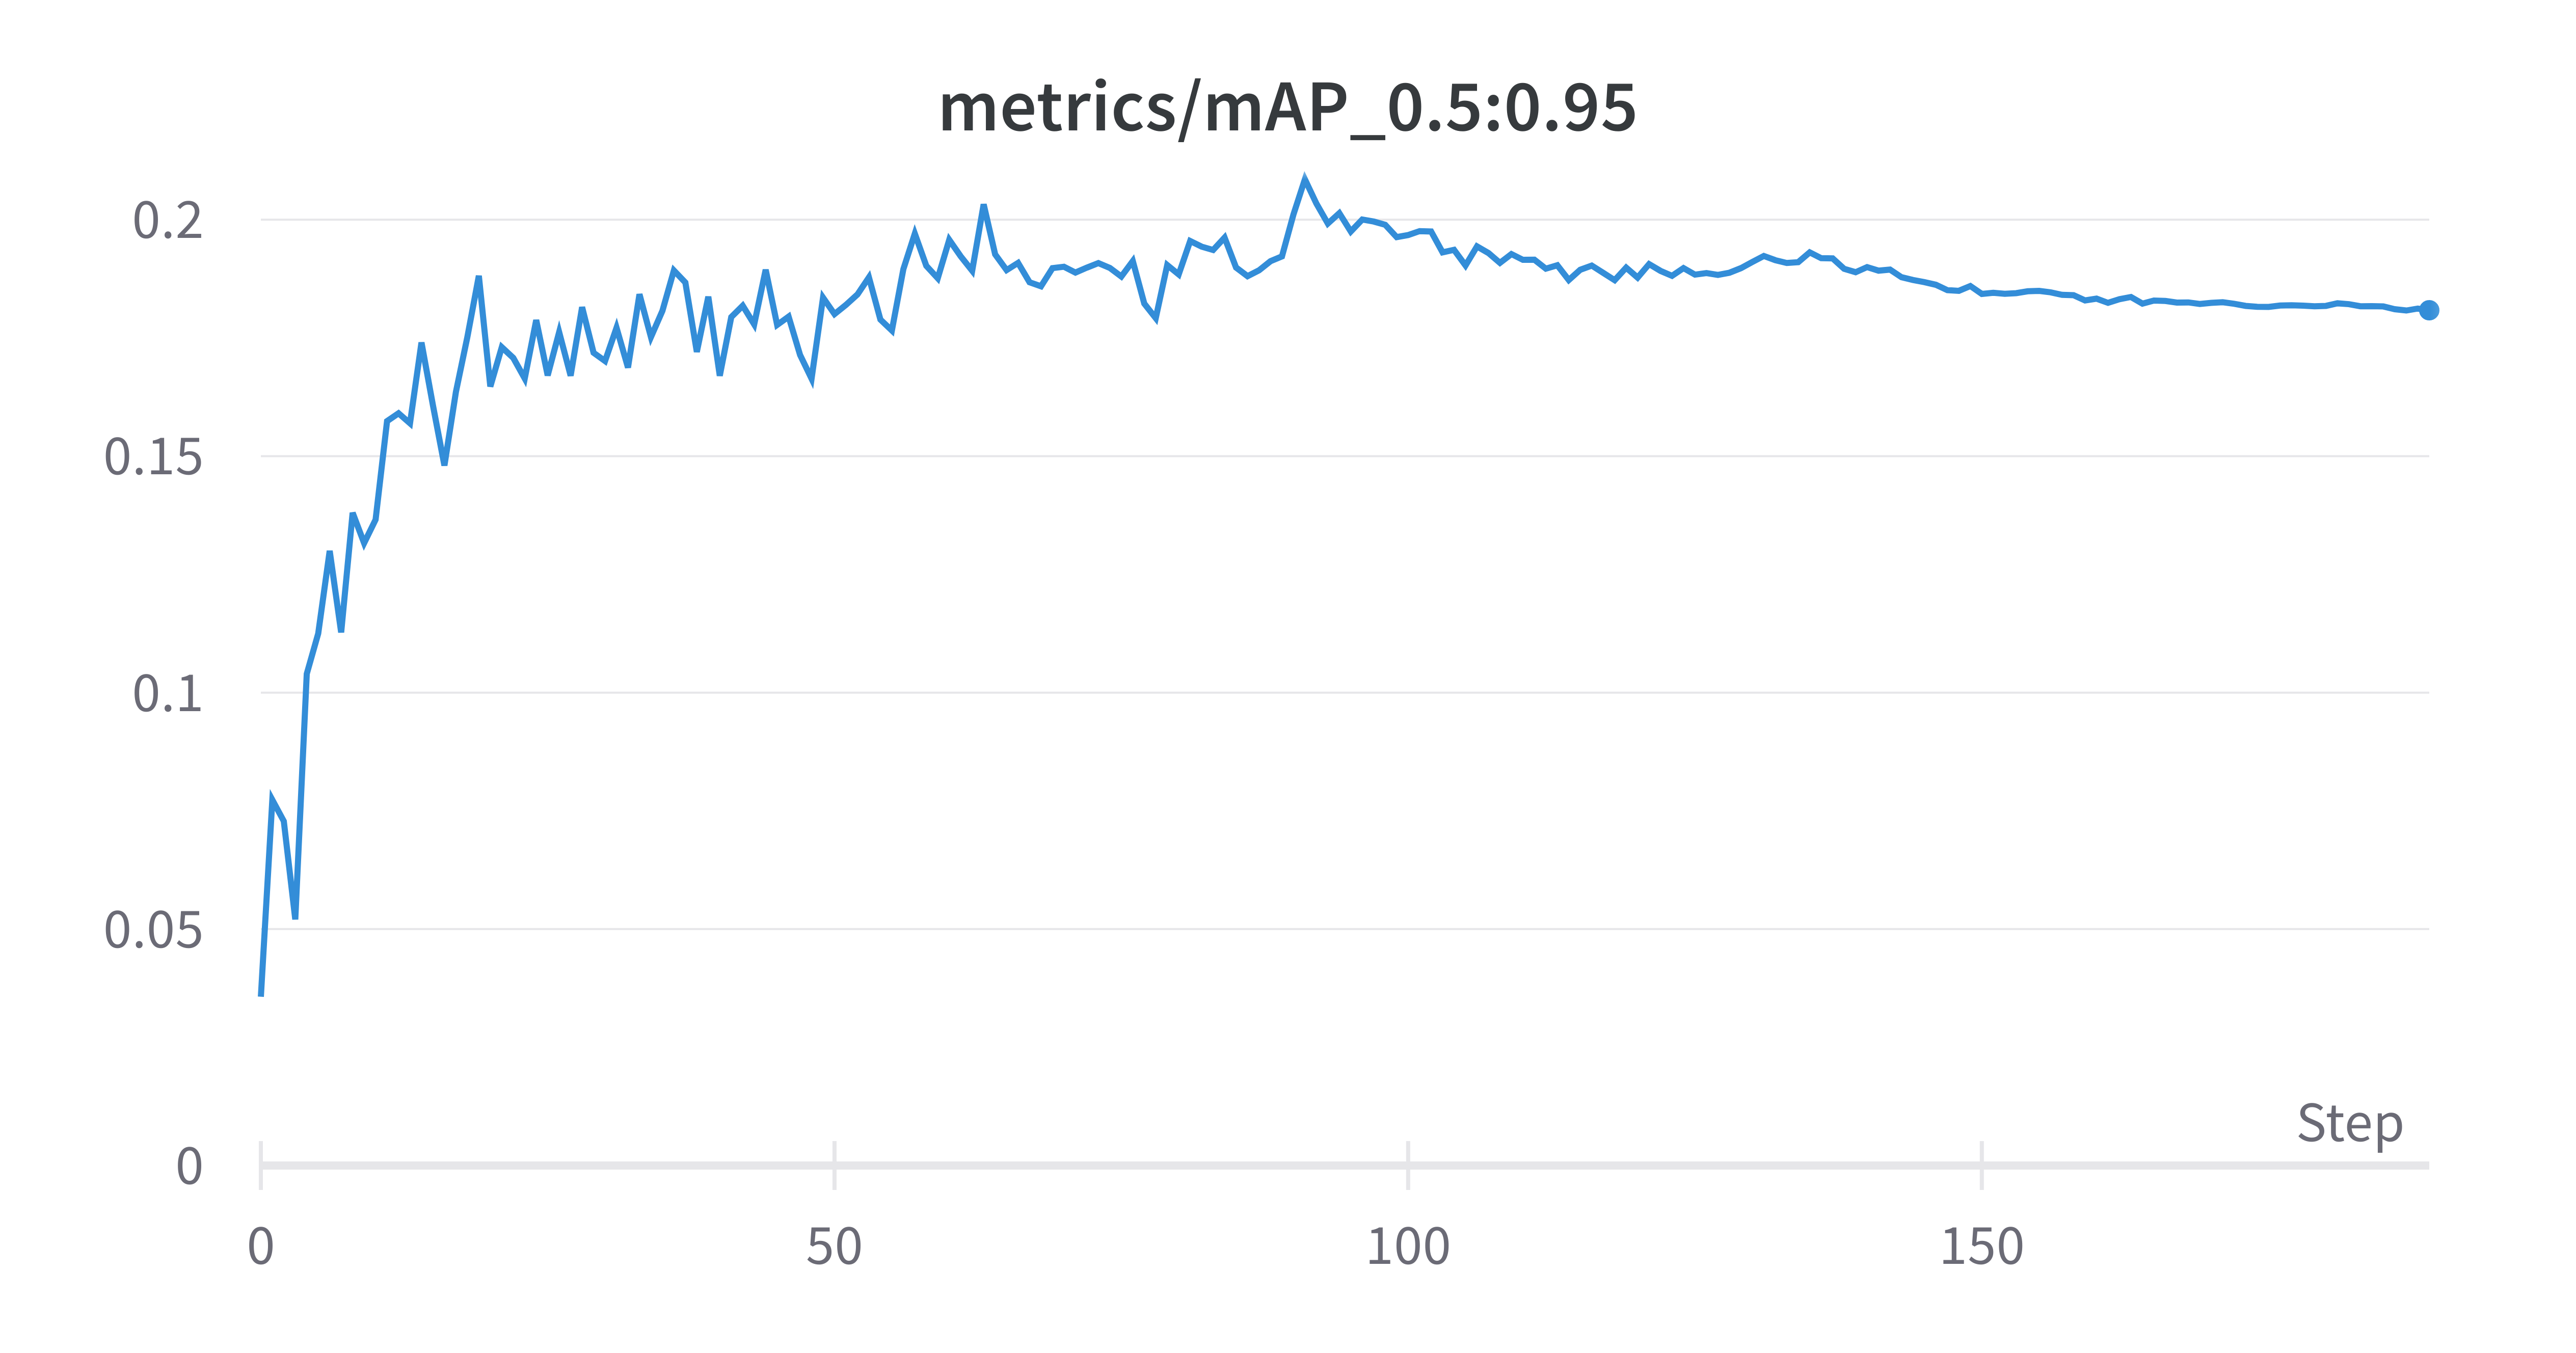

In [ ]:
display(Image('assets/model_results/percision.png', width=480, height=270))
display(Image('assets/model_results/map.png', width=480, height=270))

### Inference <a class="anchor" id="inf"></a>

<b>To run the inference on the test set, we developed a script that reads the test.csv and generates a submission file with the predictions.<br><br>
We used the following command to run the inference:</b>

```bash
python inference.py --model_name pattrn --segments 8
```

<b> For details on the inference script and arguments, please check the [inference.py](inference.py) file.


In [ ]:
# read results csv file
results_df = pd.read_csv('results/pattrn.csv')
results_df.head()

class                            image_path           name        xmax  \
0    7.0  953ab1447c46ecfef67ab14629cd70c7.jpg  BAD_BILLBOARD  702.206055   
1    3.0  953ab1447c46ecfef67ab14629cd70c7.jpg        GARBAGE  430.393494   
2    3.0  953ab1447c46ecfef67ab14629cd70c7.jpg        GARBAGE  442.626831   
3    3.0  e4ddbaa7970fca225a51288ce5f7d3f9.jpg        GARBAGE  629.232666   
4    2.0  5b8120d69607a077b7583334be3ba18b.jpg       POTHOLES  420.416687   

         xmin        ymax        ymin  
0  606.064270  223.548523  172.292542  
1  383.134216  284.195374  250.328766  
2  391.968872  299.036926  261.221252  
3  500.051025  417.305786  325.299500  
4  197.771576  521.767883  316.614319

BAD_BILLBOARD:


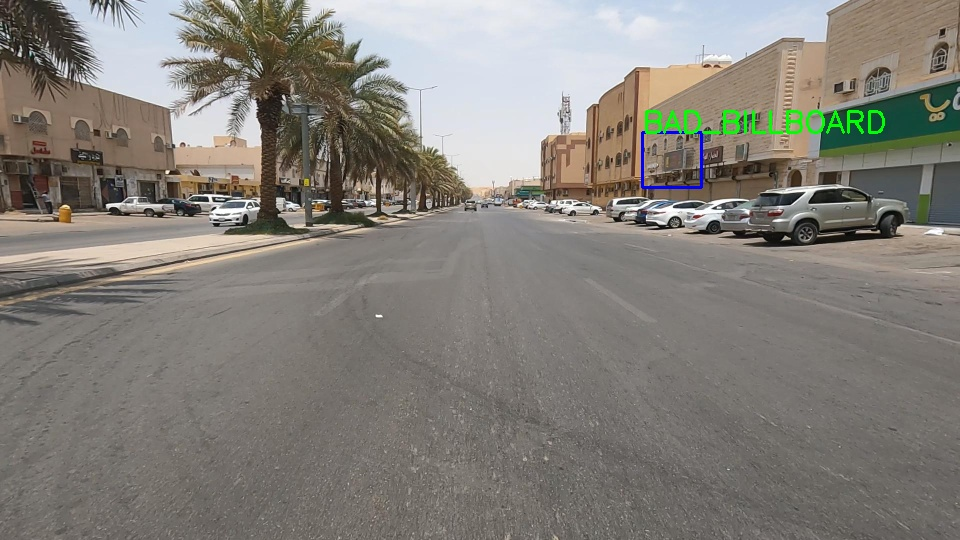

UNKEPT_FACADE:


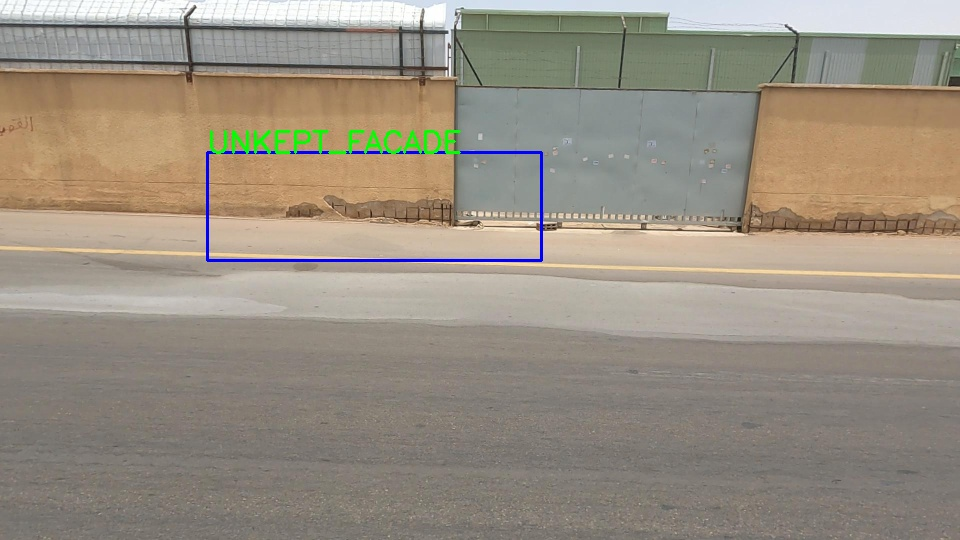

SAND_ON_ROAD:


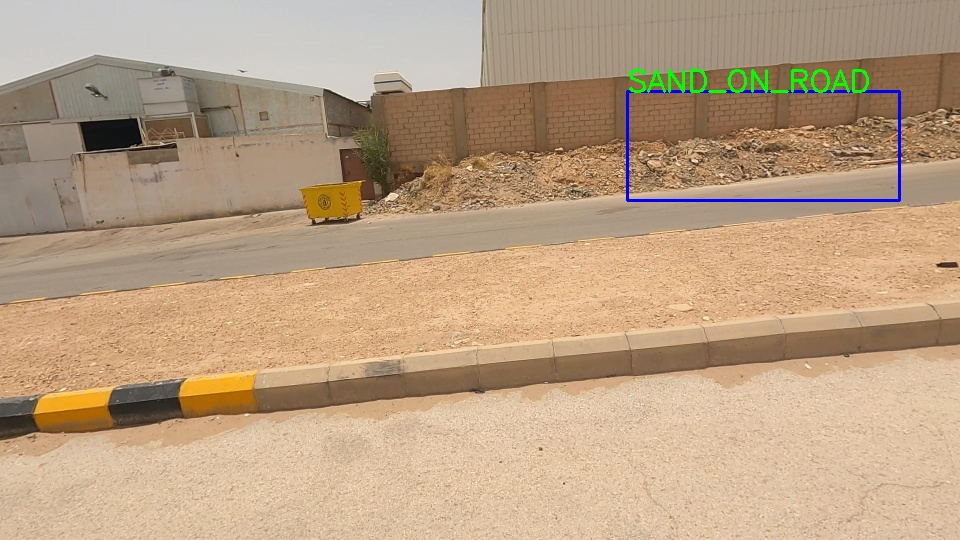

CLUTTER_SIDEWALK:


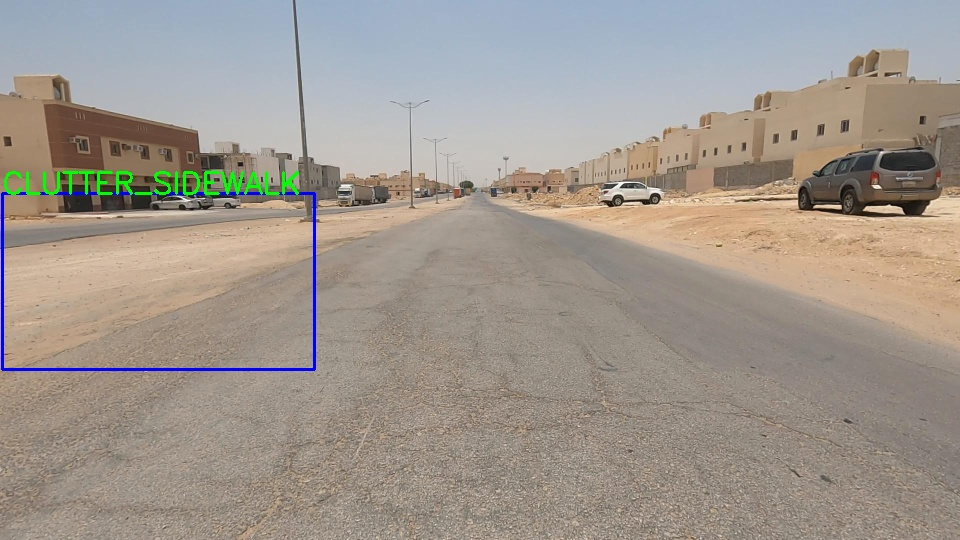

POTHOLES:


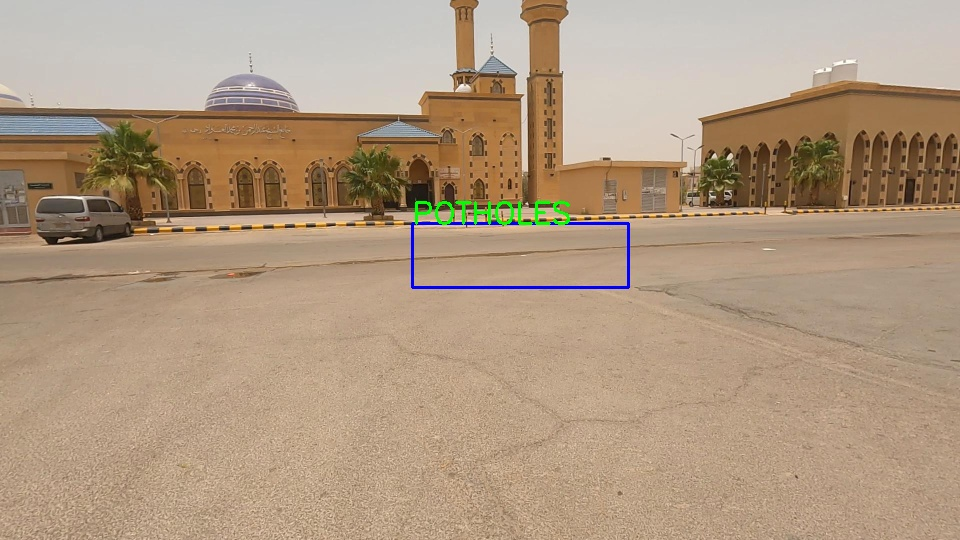

GRAFFITI:


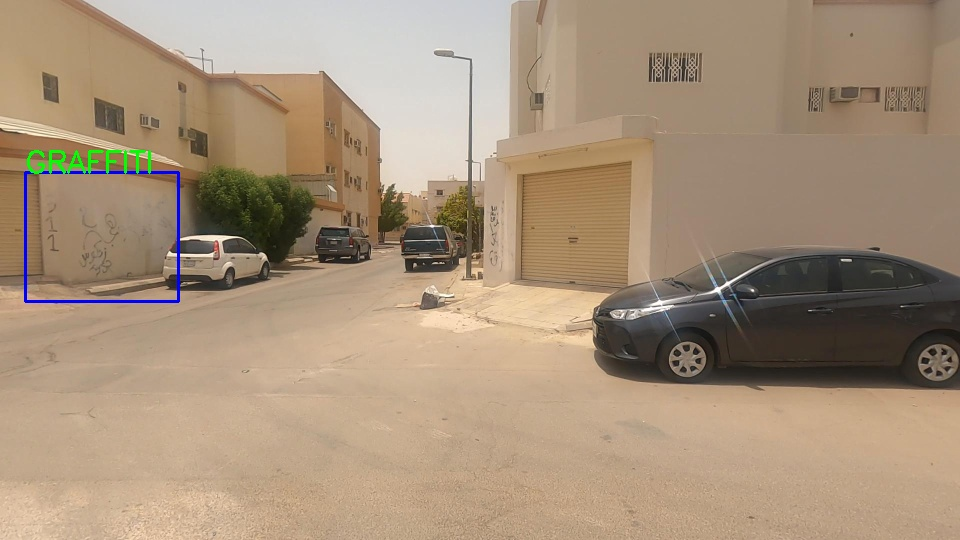

BROKEN_SIGNAGE:


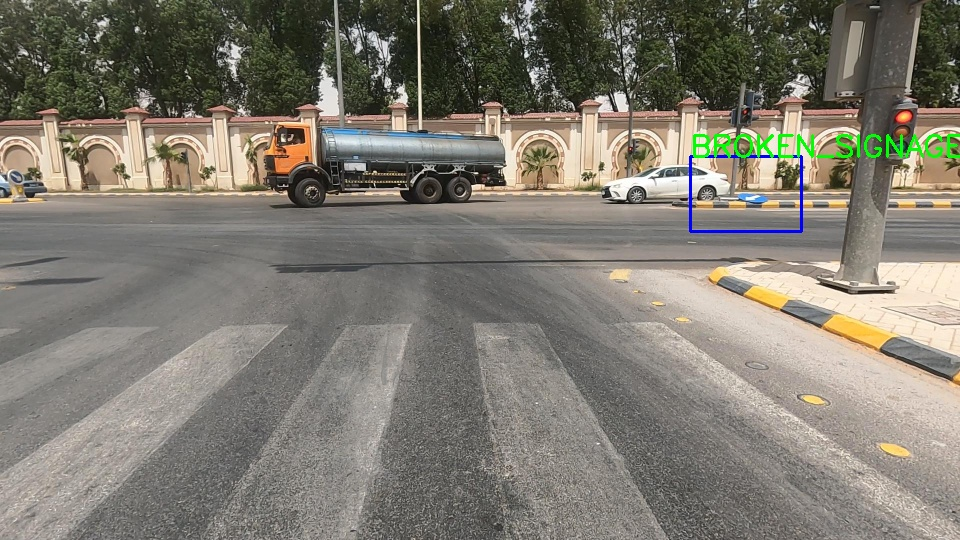

GARBAGE:


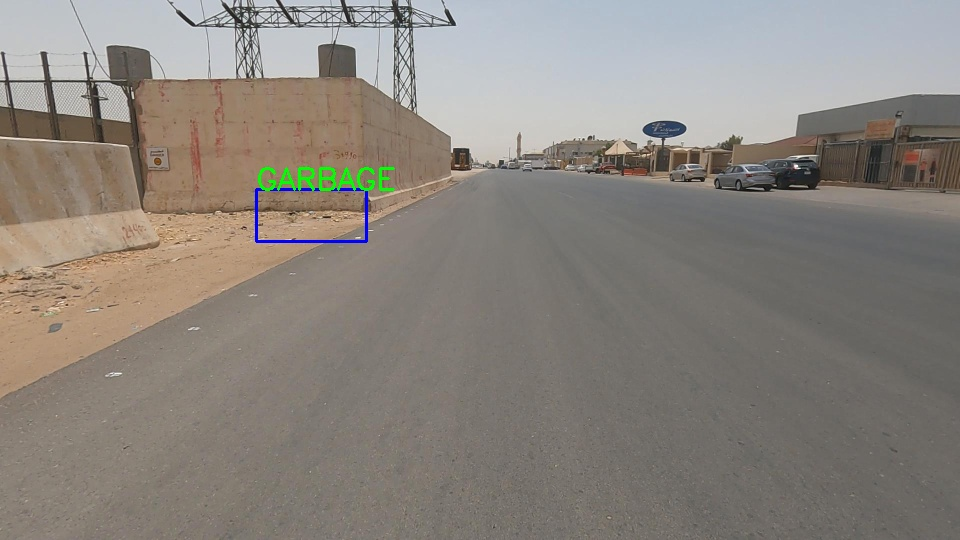

FADED_SIGNAGE:


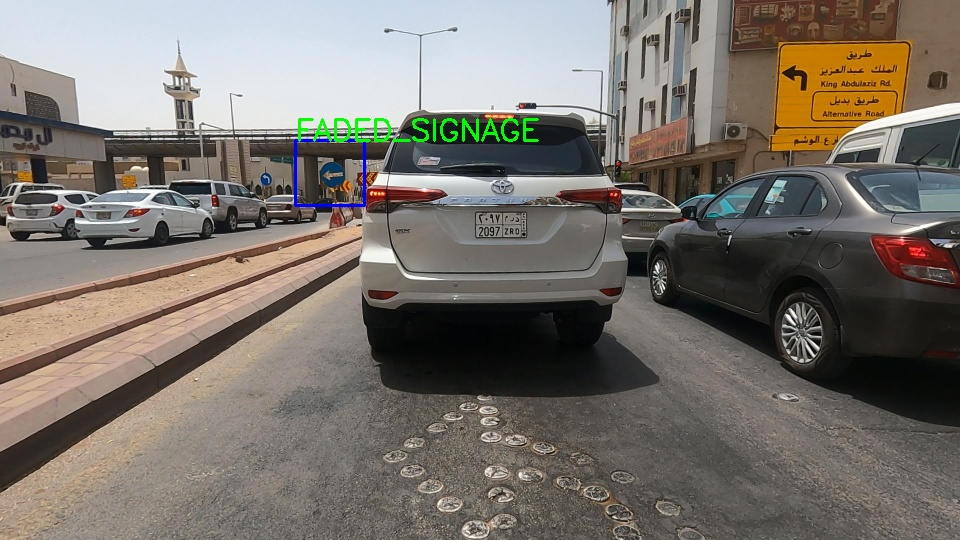

CONSTRUCTION_ROAD:


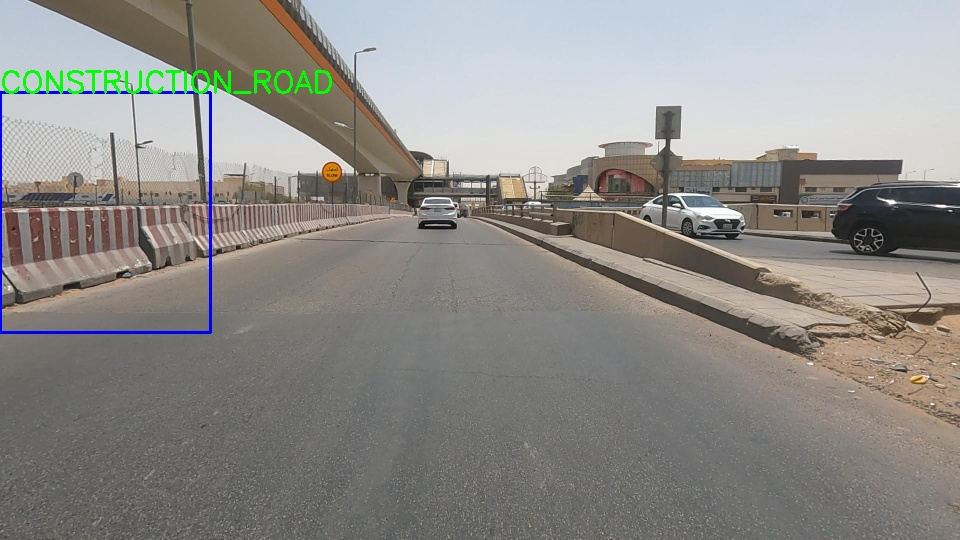

In [ ]:
results_df = pd.read_csv('results/pattrn.csv')
results_df['image_path'] = 'dataset/images/' + results_df['image_path']

# display sample results, one image per class, with bounding boxes and labels, with one label only
a = results_df.groupby('name').apply(lambda x: x.sample(1)).reset_index(drop=True)

# convert coordinates to int for visualization
a['xmin'] = a['xmin'].astype(int)
a['ymin'] = a['ymin'].astype(int)
a['xmax'] = a['xmax'].astype(int)
a['ymax'] = a['ymax'].astype(int)


a = a.groupby('image_path')['xmin', 'ymin', 'xmax', 'ymax', 'name'].apply(lambda x: x.values.tolist()).reset_index(name='bboxes')
a['labels'] = a['bboxes'].apply(lambda x: [i[4] for i in x])
a['bboxes'] = a['bboxes'].apply(lambda x: [i[:4] for i in x])

for i in range(len(a)):
    img = cv2.imread(a['image_path'].iloc[i])
    img = cv2.resize(img, (960, 540))
    for j in range(len(a['bboxes'].iloc[i])):
        print(a['labels'].iloc[i][j]+":")
        cv2.rectangle(img, tuple(a['bboxes'].iloc[i][j][:2]), tuple(a['bboxes'].iloc[i][j][2:]), (255, 0, 0), 2)
        cv2.putText(img, a['labels'].iloc[i][j], tuple(a['bboxes'].iloc[i][j][:2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imwrite('assets/sample_images/{}.jpg'.format(i), img)
    display(Image('assets/sample_images/{}.jpg'.format(i)))